In [1]:
import time, itertools, copy, warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adamax
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

#############################################
# 1. 데이터셋 준비
#############################################

# 데이터셋 경로
train_dir = "D:/kaggle_dataset/tomato_disease/train"
# train_dir = "D:/kaggle_dataset/rice/train"
# train_dir = "D:/kaggle_dataset/pistachio/train"

# 전처리 정의
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# 1. 라벨만 얻기 위한 dataset (transform=None)
base_dataset = datasets.ImageFolder(root=train_dir)
targets = [s[1] for s in base_dataset.samples]
indices = list(range(len(base_dataset)))

# Stratified split: Train 70%, Val 15%, Test 15%
train_idx, temp_idx = train_test_split(
    indices, train_size=0.7, stratify=targets, random_state=123
)
temp_targets = [targets[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_targets, random_state=123
)

# 2. transform이 적용된 버전 3개 불러오기
full_train = datasets.ImageFolder(root=train_dir, transform=train_transform)
full_val = datasets.ImageFolder(root=train_dir, transform=val_test_transform)
full_test = datasets.ImageFolder(root=train_dir, transform=val_test_transform)

# 3. Subset 적용
train_dataset = Subset(full_train, train_idx)
valid_dataset = Subset(full_val, val_idx)
test_dataset = Subset(full_test, test_idx)

# 4. DataLoader 생성
batch_size = 40
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# 테스트 배치 사이즈 자동 설정 (최대 80 이하)
ts_length = len(test_dataset)
possible_bs = [
    ts_length // n
    for n in range(1, ts_length + 1)
    if ts_length % n == 0 and (ts_length / n) <= 80
]
test_batch_size = max(possible_bs) if possible_bs else batch_size
test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2
)

# 정리
dataloaders = {"train": train_loader, "val": valid_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(valid_dataset)}
class_count = len(full_train.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#############################################
# 2. 학습 함수 정의
#############################################
def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=5,
    device=device,
    patience=3,
):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    early_stop_counter = 0  # 얼리스탑 카운터 초기화

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())
                scheduler.step(epoch_loss)

                # 얼리스탑 조건 검사
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0  # 성능 향상 → 초기화
                else:
                    early_stop_counter += 1
                    print(
                        f"No improvement. Early stopping counter: {early_stop_counter}/{patience}"
                    )
                    if early_stop_counter >= patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print(f"Training stopped early at epoch {epoch+1}")
                        print(
                            f"Time elapsed: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
                        )
                        print(f"Best val Acc: {best_acc:.4f}")
                        return model, history

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

In [5]:
#############################################
# 3. 모델 3개 정의
#############################################
# 모델 예시 1: EfficientNetB3 기반 모델
model1 = models.efficientnet_b3(pretrained=True)
in_features1 = model1.classifier[1].in_features
model1.classifier = nn.Sequential(
    nn.BatchNorm1d(in_features1),
    nn.Linear(in_features1, 256),
    nn.ReLU(),
    nn.Dropout(0.45),
    nn.Linear(256, class_count),
)
model1 = model1.to(device)

# 모델 예시 2: ResNet50 기반 모델
model2 = models.resnet50(pretrained=True)
in_features2 = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.BatchNorm1d(in_features2),
    nn.Linear(in_features2, 256),
    nn.ReLU(),
    nn.Dropout(0.45),
    nn.Linear(256, class_count),
)
model2 = model2.to(device)

# 모델 예시 3: VGG16 기반 모델
model3 = models.vgg16(pretrained=True)
in_features3 = model3.classifier[
    0
].in_features  # VGG의 첫 번째 Fully Connected Layer 입력 크기
model3.classifier = nn.Sequential(
    nn.BatchNorm1d(in_features3),
    nn.Linear(in_features3, 256),
    nn.ReLU(),
    nn.Dropout(0.45),
    nn.Linear(256, class_count),  # 최종 레이어: 클래스 개수로 출력 조정
)
model3 = model3.to(device)

In [4]:
#############################################
# 3. 모델 3개 정의
#############################################
# 모델 예시 1: EfficientNetB3 기반 모델
model1 = models.efficientnet_b3(pretrained=True)
in_features1 = model1.classifier[1].in_features
model1.classifier = nn.Sequential(
    nn.Linear(in_features1, 512),
    nn.SiLU(),                   # EfficientNet 기본 활성화 함수
    nn.Dropout(0.3),
    nn.Linear(512, class_count)
)
model1 = model1.to(device)

# 모델 예시 2: ResNet50 기반 모델
model2 = models.resnet50(pretrained=True)
in_features2 = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(in_features2, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, class_count)
)
model2 = model2.to(device)

# 모델 예시 3: VGG16 기반 모델
model3 = models.vgg16(pretrained=True)
in_features3 = model3.classifier[
    0
].in_features  # VGG의 첫 번째 Fully Connected Layer 입력 크기
model3.classifier = nn.Sequential(
    nn.Linear(in_features3, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6),

    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(128, class_count)
)
model3 = model3.to(device)

In [8]:
# 로컬 그래픽카드 메모리 부족 아슈..
gc.collect()
torch.cuda.empty_cache()

In [6]:
 #############################################
# 4. 모델 학습 및 결과 저장
#############################################
import gc

num_epochs = 20
criterion = nn.CrossEntropyLoss()
histories1 = {}

# EfficientNetB3 학습
optimizer1 = Adamax(model1.parameters(), lr=0.001)
scheduler1 = ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=1, verbose=True)
print("Training EfficientNetB3 Model")
model1, history1 = train_model(model1, dataloaders, criterion, optimizer1, scheduler1, num_epochs, patience=3)
histories1['EfficientNetB3'] = history1

# 로컬 그래픽카드 메모리 부족 아슈..
gc.collect()
torch.cuda.empty_cache()

Training EfficientNetB3 Model
Epoch 1/20
----------
train Loss: 0.4056 Acc: 0.8702
val Loss: 0.1157 Acc: 0.9580

Epoch 2/20
----------
train Loss: 0.1077 Acc: 0.9651
val Loss: 0.0678 Acc: 0.9812

Epoch 3/20
----------
train Loss: 0.0629 Acc: 0.9806
val Loss: 0.0630 Acc: 0.9801
No improvement. Early stopping counter: 1/3

Epoch 4/20
----------
train Loss: 0.0426 Acc: 0.9866
val Loss: 0.0517 Acc: 0.9879

Epoch 5/20
----------
train Loss: 0.0318 Acc: 0.9903
val Loss: 0.0564 Acc: 0.9881

Epoch 6/20
----------
train Loss: 0.0282 Acc: 0.9915
val Loss: 0.0538 Acc: 0.9884

Epoch 7/20
----------
train Loss: 0.0129 Acc: 0.9958
val Loss: 0.0463 Acc: 0.9899

Epoch 8/20
----------
train Loss: 0.0113 Acc: 0.9962
val Loss: 0.0450 Acc: 0.9902

Epoch 9/20
----------
train Loss: 0.0083 Acc: 0.9973
val Loss: 0.0509 Acc: 0.9899
No improvement. Early stopping counter: 1/3

Epoch 10/20
----------
train Loss: 0.0081 Acc: 0.9977
val Loss: 0.0496 Acc: 0.9905

Epoch 11/20
----------
train Loss: 0.0056 Acc: 0.99

In [7]:
# ResNet50 학습
optimizer2 = Adamax(model2.parameters(), lr=0.001)
scheduler2 = ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=1, verbose=True)
print("Training ResNet50 Model")
model2, history2 = train_model(model2, dataloaders, criterion, optimizer2, scheduler2, num_epochs, patience=3)
histories1['ResNet50'] = history2

gc.collect()
torch.cuda.empty_cache()

Training ResNet50 Model
Epoch 1/20
----------
train Loss: 0.5441 Acc: 0.8207
val Loss: 0.4172 Acc: 0.8682

Epoch 2/20
----------
train Loss: 0.2860 Acc: 0.9076
val Loss: 0.2988 Acc: 0.8971

Epoch 3/20
----------
train Loss: 0.2001 Acc: 0.9335
val Loss: 0.1775 Acc: 0.9448

Epoch 4/20
----------
train Loss: 0.1670 Acc: 0.9448
val Loss: 0.1911 Acc: 0.9404
No improvement. Early stopping counter: 1/3

Epoch 5/20
----------
train Loss: 0.1179 Acc: 0.9611
val Loss: 0.1116 Acc: 0.9621

Epoch 6/20
----------
train Loss: 0.1062 Acc: 0.9647
val Loss: 0.1165 Acc: 0.9644

Epoch 7/20
----------
train Loss: 0.0870 Acc: 0.9715
val Loss: 0.0893 Acc: 0.9698

Epoch 8/20
----------
train Loss: 0.0667 Acc: 0.9802
val Loss: 0.0923 Acc: 0.9693
No improvement. Early stopping counter: 1/3

Epoch 9/20
----------
train Loss: 0.0579 Acc: 0.9812
val Loss: 0.1467 Acc: 0.9582
No improvement. Early stopping counter: 2/3

Epoch 10/20
----------
train Loss: 0.0229 Acc: 0.9928
val Loss: 0.0608 Acc: 0.9848

Epoch 11/20
-

In [8]:
# vgg16 학습
optimizer3 = Adamax(model3.parameters(), lr=0.001)
scheduler3 = ReduceLROnPlateau(optimizer3, mode='min', factor=0.5, patience=1, verbose=True)
print("Training VGG16 Model")
model3, history3 = train_model(model3, dataloaders, criterion, optimizer3, scheduler3, num_epochs, patience=3)
histories1['VGG16'] = history3

gc.collect()
torch.cuda.empty_cache()

Training VGG16 Model
Epoch 1/20
----------
train Loss: 1.2196 Acc: 0.5784
val Loss: 1.2537 Acc: 0.6831

Epoch 2/20
----------
train Loss: 0.6928 Acc: 0.7646
val Loss: 1.3176 Acc: 0.6235
No improvement. Early stopping counter: 1/3

Epoch 3/20
----------
train Loss: 0.5226 Acc: 0.8185
val Loss: 1.0667 Acc: 0.6978

Epoch 4/20
----------
train Loss: 0.4284 Acc: 0.8521
val Loss: 0.6969 Acc: 0.7599

Epoch 5/20
----------
train Loss: 0.3476 Acc: 0.8784
val Loss: 0.3986 Acc: 0.8711

Epoch 6/20
----------
train Loss: 0.3384 Acc: 0.8808
val Loss: 0.3998 Acc: 0.8953

Epoch 7/20
----------
train Loss: 0.2434 Acc: 0.9152
val Loss: 1.1657 Acc: 0.8742
No improvement. Early stopping counter: 1/3

Epoch 8/20
----------
train Loss: 0.1798 Acc: 0.9376
val Loss: 0.3866 Acc: 0.9219

Epoch 9/20
----------
train Loss: 0.1601 Acc: 0.9429
val Loss: 5.1042 Acc: 0.8914
No improvement. Early stopping counter: 1/3

Epoch 10/20
----------
train Loss: 0.1436 Acc: 0.9508
val Loss: 0.4524 Acc: 0.9278

Epoch 11/20
----

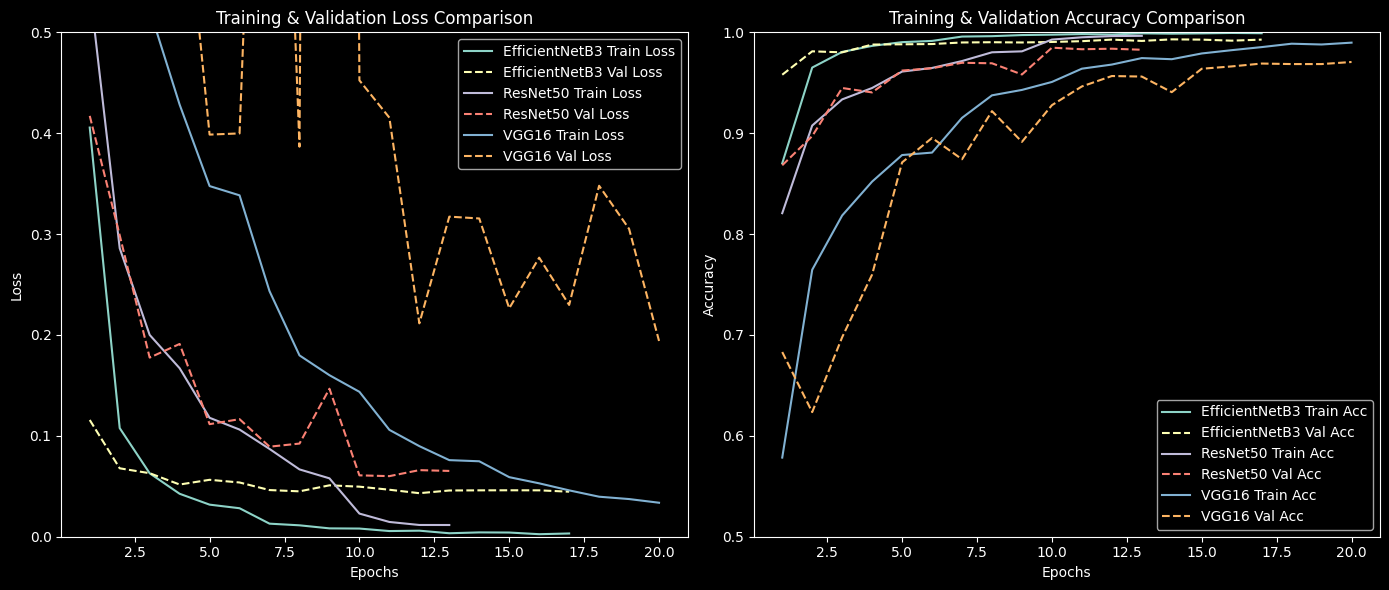

In [9]:
# import seaborn as sns

plt.figure(figsize=(14, 6))
# sns.set_theme(style="darkgrid", palette="dark", context="notebook")

# Loss 비교
plt.subplot(1, 2, 1)
for model_name, hist in histories1.items():
    epochs = range(1, len(hist['train_loss']) + 1)
    plt.plot(epochs, hist['train_loss'], label=f'{model_name} Train Loss')
    plt.plot(epochs, hist['val_loss'], '--', label=f'{model_name} Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.title('Training & Validation Loss Comparison')
plt.legend()

# Accuracy 비교
plt.subplot(1, 2, 2)
for model_name, hist in histories1.items():
    epochs = range(1, len(hist['train_acc']) + 1)
    plt.plot(epochs, hist['train_acc'], label=f'{model_name} Train Acc')
    plt.plot(epochs, hist['val_acc'], '--', label=f'{model_name} Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Comparison')
plt.ylim(0.5, 1)
plt.legend()

plt.tight_layout()
plt.show()

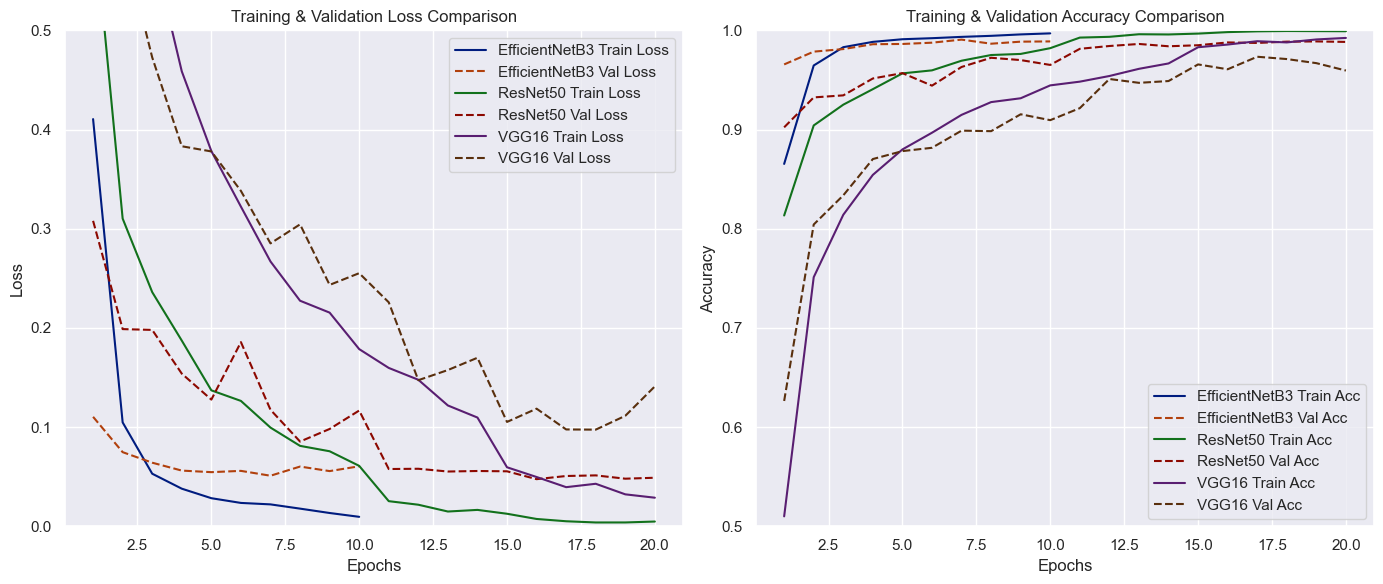

In [10]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.set_theme(style="darkgrid", palette="dark", context="notebook")

# Loss 비교
plt.subplot(1, 2, 1)
for model_name, hist in histories1.items():
    epochs = range(1, len(hist['train_loss']) + 1)
    plt.plot(epochs, hist['train_loss'], label=f'{model_name} Train Loss')
    plt.plot(epochs, hist['val_loss'], '--', label=f'{model_name} Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.title('Training & Validation Loss Comparison')
plt.legend()

# Accuracy 비교
plt.subplot(1, 2, 2)
for model_name, hist in histories1.items():
    epochs = range(1, len(hist['train_acc']) + 1)
    plt.plot(epochs, hist['train_acc'], label=f'{model_name} Train Acc')
    plt.plot(epochs, hist['val_acc'], '--', label=f'{model_name} Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Comparison')
plt.ylim(0.5, 1)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
histories1['EfficientNetB3']['val_acc'][-1], histories1['ResNet50']['val_acc'][-1], histories1['VGG16']['val_acc'][-1]

(0.9927797833935018, 0.9827230531201651, 0.9706034038164002)

In [19]:
list(histories1.keys())[0]

'EfficientNetB3'

In [21]:
histories1

{'EfficientNetB3': {'train_loss': [0.4056154580266478,
   0.10767771467683838,
   0.06289941842805952,
   0.04257608829251444,
   0.031798289653027556,
   0.028238700840464693,
   0.01294601792272432,
   0.011306101601666962,
   0.0082834375840948,
   0.008093561119143973,
   0.005622906404653491,
   0.005988738991005499,
   0.003440705588986916,
   0.004278320121411535,
   0.004154179565172612,
   0.0025007188698939952,
   0.0032165702391500693],
  'train_acc': [0.8701851340149213,
   0.9650732246476927,
   0.9806023763470572,
   0.9865708759325781,
   0.990273556231003,
   0.9914893617021276,
   0.9957999447361149,
   0.9961867919314727,
   0.9972920696324952,
   0.9976789168278529,
   0.9982868195634153,
   0.9978447084830063,
   0.9990052500690798,
   0.9986736667587731,
   0.9989499861840287,
   0.9993920972644377,
   0.999115777839182],
  'val_loss': [0.11571985782595287,
   0.06781795264815872,
   0.06296312839538243,
   0.0517449222496447,
   0.05642954717285652,
   0.053766451

In [ ]:
import psycopg2
from psycopg2 import sql

# 데이터베이스 연결 설정
conn = psycopg2.connect(
    dbname="ktb_project",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# 커서 생성
cur = conn.cursor()


# 각 모델에 대해 데이터 삽입
for model, values in histories1.items():
    for epoch in range(len(values['train_loss'])):
        cur.execute(
            sql.SQL("""
            INSERT INTO tomato_disease (model, epoch, train_acc, train_loss, val_acc, val_loss)
            VALUES (%s, %s, %s, %s, %s, %s)
            """),
            (
                model,
                epoch + 1,
                values['train_acc'][epoch],
                values['train_loss'][epoch],
                values['val_acc'][epoch],
                values['val_loss'][epoch]
            )
        )

# 변경사항 커밋
conn.commit()

# 연결 종료
cur.close()
conn.close()

print("데이터가 성공적으로 삽입되었습니다.")


데이터가 성공적으로 삽입되었습니다.
